In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import glob
import re
import locale
locale.setlocale(locale.LC_ALL, '')

rx_dict = {
    'inputfile': re.compile(r'Input file: (?P<inputfile>.*)\n'),
    'seed': re.compile(r'RNG seed: (?P<seed>.*)\n'),
	'iter_resfriamento': re.compile(r'Iteracoes para resfriamento: (?P<iter_resfriamento>.*)\n'),
	'iter_metropoles': re.compile(r'Iteracoes para metropoles: (?P<iter_metropoles>.*)\n'),
	'resfriamento': re.compile(r'Resfriamento: (?P<resfriamento>.*)\n'),
	'temperatura': re.compile(r'Temperatura inicial: (?P<temperatura>.*)\n'),
	'tempo_real': re.compile(r'Tempo real (?P<tempo_real>.*)\n'),
	'tempo_cpu': re.compile(r'Tempo CPU (?P<tempo_cpu>.*)\n'),
	'value': re.compile(r'Final one: (?P<value>.[0-9]+)\n'),
}

bkv = {
	'trsp_50_1': 1906,
	'trsp_50_2': 1888 ,
	'trsp_50_3': 1532 ,
	'trsp_50_4': 1726 ,
	'trsp_100_1': 3558,
	'trsp_100_2': 3220,
	'trsp_100_3': 3731,
	'trsp_100_4': 2792,
	'trsp_1000_1': 35035,
	'trsp_1000_2': 34148,
	'trsp_1000_3': 34124,
	'trsp_1000_4': 34340
}

initial_solution = {
	'trsp_50_1': 2141,
	'trsp_50_2': 2106,
	'trsp_50_3': 1644,
	'trsp_50_4': 1874,
	'trsp_100_1': 4027,
	'trsp_100_2': 3731,
	'trsp_100_3': 4260,
	'trsp_100_4': 3092,
	'trsp_1000_1': 40093,
	'trsp_1000_2': 38356,
	'trsp_1000_3': 38285,
	'trsp_1000_4': 38603
}

def parse_line(line):
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            return key, match
    # if there are no matches
    return None, None

def to_seconds(val:str):
	if val.endswith('ms'):
		return locale.atof(val.replace('ms','').replace('.',','))/1000
	else:
		return locale.atof(val.replace('s','').replace('.',','))


def iterations(ti:float, r:float):
	return np.ceil(-np.log(ti)/np.log(r))

data = pd.DataFrame()

paths = list(map(lambda p: (int(p.split('\\')[1].split('.')[0]), p), glob.glob("./logs/*.log")))
sorted_paths = sorted(paths, key=lambda t: t[0])
for i, filepath in sorted_paths:
	file_data = {}
	with open(filepath, 'r') as file_obj:
		for line in file_obj.readlines():
			key, match  = parse_line(line) 
			match key:
				case None:
					continue
				case 'inputfile':
					dataset = match.group(key).replace('\"','').split('/')[1].split('.')[0]
					name = dataset.split('_')
					file_data[key] = int(name[1]) + float(name[2])/10
					file_data['bkv'] = bkv[dataset]
					file_data['solucao_inicial'] = initial_solution[dataset]
				case 'tempo_real':
					file_data[key] = f'{to_seconds(match.group(key)):.3f}s'
				case 'tempo_cpu':
					file_data[key] = f'{to_seconds(match.group(key)):.3f}s'
				case _:
					file_data[key] = match.group(key)
	
	file_data['desvio_bkv'] = ((float(file_data['value']) / file_data['bkv']) * 100 - 100)
	file_data['desvio_solucao_ini'] = f"{((float(file_data['value']) / file_data['solucao_inicial']) * 100 - 100):.4f}"#.replace('.',',')
	file_data['num_total_de_iter'] = int(iterations(float(file_data['temperatura']), float(file_data['resfriamento'])) \
	    * float(file_data['iter_resfriamento']) * float(file_data['iter_metropoles']))
	f_data = pd.DataFrame([file_data])
	file_data.clear()
	data = pd.concat([data, f_data], ignore_index=True)
#data = data.append([file_data], ignore_index=True, sort=False)
#print(data)
	
data = data[['inputfile','seed','temperatura','iter_resfriamento',
	    'iter_metropoles', 'num_total_de_iter', 'resfriamento',
		'tempo_real','tempo_cpu',
		'solucao_inicial', 'value','bkv','desvio_bkv', 'desvio_solucao_ini']]
#data.to_csv('all_logs.csv')

#print(data)
#data.mask(data == 0).boxplot()
#data.replace(0.0, np.nan)

#print(data.head(20))


a entrada 50.1 equivale ao arquivo de entrada trsp_50_1


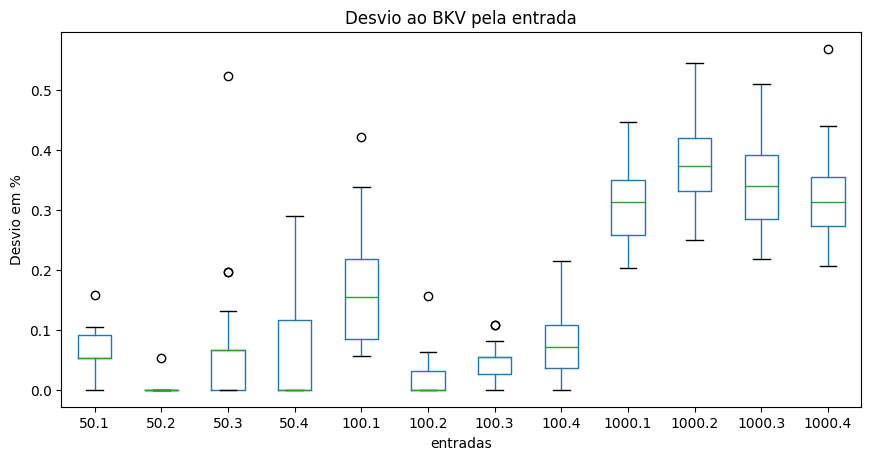

In [65]:
box = data.boxplot(figsize=(10,5), by ='inputfile', column =['desvio_bkv'], grid = False)
#order = ['50_1','50_2','50_3','50_4','100_1','100_2','100_3','100_4','1000_1','1000_2','1000_3','1000_4']

plt.suptitle('')
plt.title('Desvio ao BKV pela entrada')
plt.xlabel('entradas')
print('a entrada 50.1 equivale ao arquivo de entrada trsp_50_1')
plt.ylabel('Desvio em %')
plt.show()

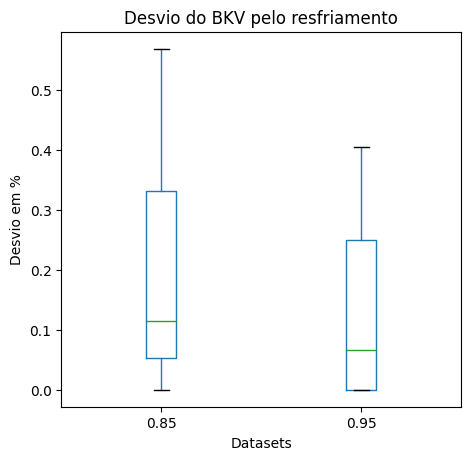

In [66]:
box = data.boxplot(figsize=(5,5), by=['resfriamento'], column =['desvio_bkv'], grid = False)

plt.suptitle('')
plt.title('Desvio do BKV pelo resfriamento')
plt.xlabel('Datasets')
plt.ylabel('Desvio em %')
plt.show()


In [68]:
d = data[['inputfile', 'solucao_inicial', 'value', 'bkv', 'desvio_bkv','desvio_solucao_ini' ]]
d = d.groupby('inputfile').agg({
    'solucao_inicial': ['min'],
    'value': ['min'],
    'bkv': ['min'],
    'desvio_bkv': ['min'],
    'desvio_solucao_ini': ['min']
})
d.head(20)
print(d.to_latex())

\begin{tabular}{lrlrrl}
\toprule
 & solucao_inicial & value & bkv & desvio_bkv & desvio_solucao_ini \\
 & min & min & min & min & min \\
inputfile &  &  &  &  &  \\
\midrule
50.100000 & 2141 & 1906 & 1906 & 0.000000 & -10.8361 \\
50.200000 & 2106 & 1888 & 1888 & 0.000000 & -10.3039 \\
50.300000 & 1644 & 1532 & 1532 & 0.000000 & -6.3260 \\
50.400000 & 1874 & 1726 & 1726 & 0.000000 & -7.6307 \\
100.100000 & 4027 & 3560 & 3558 & 0.056211 & -11.2739 \\
100.200000 & 3731 & 3220 & 3220 & 0.000000 & -13.5620 \\
100.300000 & 4260 & 3731 & 3731 & 0.000000 & -12.3239 \\
100.400000 & 3092 & 2792 & 2792 & 0.000000 & -9.5084 \\
1000.100000 & 40093 & 35106 & 35035 & 0.202654 & -12.2266 \\
1000.200000 & 38356 & 34233 & 34148 & 0.248916 & -10.4860 \\
1000.300000 & 38285 & 34198 & 34124 & 0.216856 & -10.4140 \\
1000.400000 & 38603 & 34411 & 34340 & 0.206756 & -10.5380 \\
\bottomrule
\end{tabular}

